In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

La idea es predecir cual tweet se refieren a desastres reales y cuales no

In [113]:
tweet= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [114]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [54]:
tweet[tweet['target']==0].tail()

,id,keyword,location,text,target
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0
7593,10848,NaN,NaN,I just heard a really loud bang and everyone i...,0


In [57]:
print('En el training set hay {} filas y {} columnas'.format(tweet.shape[0],tweet.shape[1]))
print('En el test set hay {} filas y {} columnas'.format(test.shape[0],test.shape[1]))

En el training set hay 7613 filas y 5 columnas
En el test set hay 3263 filas y 4 columnas


Text(0, 0.5, 'Muestras')

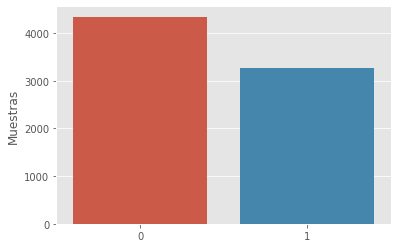

In [58]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Muestras')


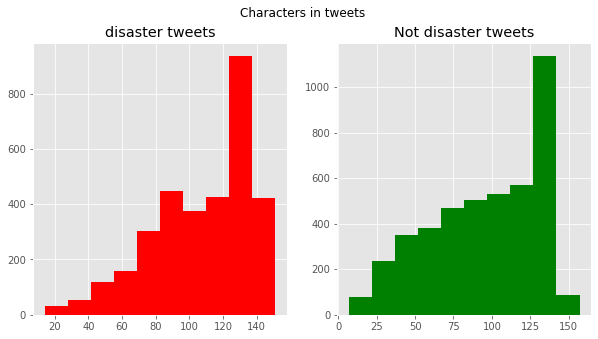

In [6]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

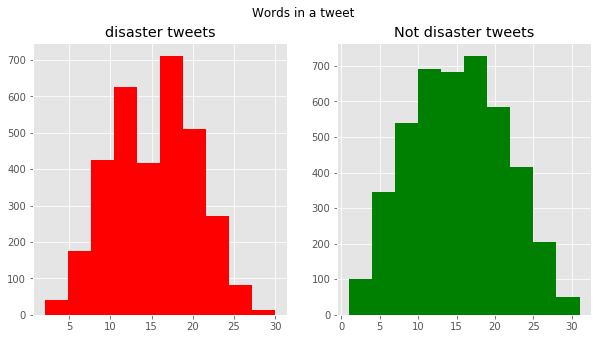

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()


Text(0.5, 0.98, 'Average word length in each tweet')

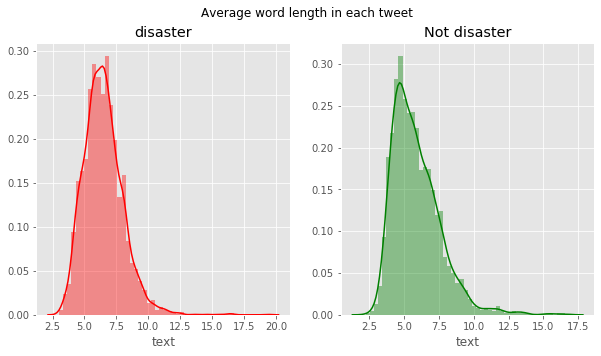

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

Creamos diccionario de palabras

In [59]:
def create_corpus(target):
    corpus=[]    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [60]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

In [64]:
corpus[:5]

["What's", 'up', 'man?', 'I', 'love']

In [77]:
list(dic.keys())[:5]

['up', 'is', 'so', 'a', 'this']

In [78]:
list(dic.values())[:5]

[167, 512, 190, 1115, 225]

 Graficamos las palabras más repetidas

<BarContainer object of 10 artists>

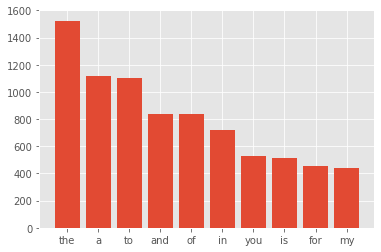

In [61]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

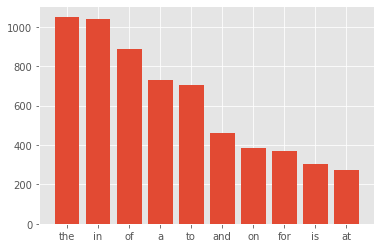

In [13]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

In [79]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation

<Figure size 720x360 with 0 Axes>

In [80]:
special

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Histograma de caracteres especiales

<BarContainer object of 18 artists>

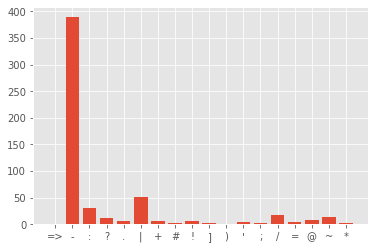

In [81]:
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

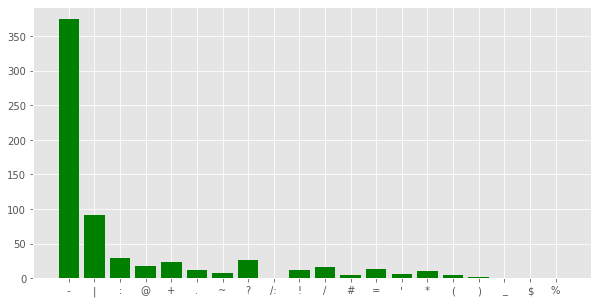

In [15]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

Más comunes incluyendo carateres especiales

In [17]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)



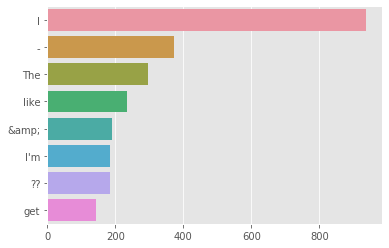

In [18]:
sns.barplot(x=y,y=x)

Bigramas más comunes

In [19]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

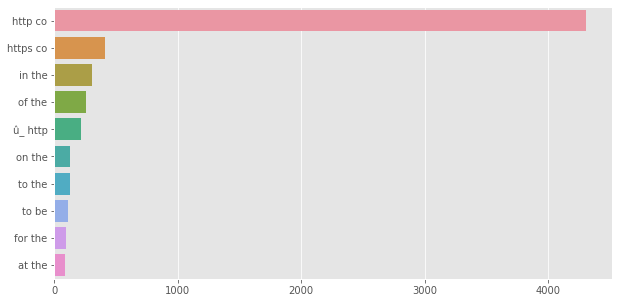

In [20]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

# Limpieza de datos

In [21]:
df=pd.concat([tweet,test])
df.shape

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 5)

In [22]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [23]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [84]:
example = """<div>
<h1>title</h1>
<p>body</p>
<a href="https://www.webpage.com/">nlp</a>
</div>"""

In [85]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


title
body
nlp



In [27]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [86]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")



'Omg another Earthquake '

In [29]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [30]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))


I am a king


## Corregimos spelling

In [31]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect"
correct_spellings(text)

'correct me please'

In [87]:
#df['text']=df['text'].apply(lambda x : correct_spellings(x))

In [35]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [36]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 5975.82it/s]


Creamos los diccionarios con el dataset limpio
GloVe es una base de datos que tiene la representacion vectorial de las palabras las comunes

In [38]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

En este caso todas las palabras son representadas como un vector de 100 componentes

In [39]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')


In [88]:
word_index=tokenizer_obj.word_index
print('Unique words:',len(word_index))

Unique words: 18694


Embedding = palabras~vectores de numeros reales

creamos la matriz de embeddings

In [41]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|██████████| 18694/18694 [00:00<00:00, 148892.01it/s]


In [93]:
embedding_dict['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

## Creamos el modelo

In [42]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1869500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,911,805
Trainable params: 42,305
Non-trainable params: 1,869,500
_________________________________________________________________


In [44]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [107]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Training',X_train.shape)
print("Validation ",X_test.shape)

Training (6471, 50)
Validation  (1142, 50)


## Entrenamos el modelo

In [46]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)


Instructions for updating:
Use tf.cast instead.
Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 34s - loss: 0.6914 - accuracy: 0.5696 - val_loss: 0.6892 - val_accuracy: 0.5727
Epoch 2/15
 - 36s - loss: 0.6846 - accuracy: 0.5701 - val_loss: 0.6711 - val_accuracy: 0.5727
Epoch 3/15
 - 40s - loss: 0.6351 - accuracy: 0.6444 - val_loss: 0.5666 - val_accuracy: 0.7706
Epoch 4/15
 - 40s - loss: 0.5984 - accuracy: 0.7073 - val_loss: 0.5359 - val_accuracy: 0.7706
Epoch 5/15
 - 36s - loss: 0.5785 - accuracy: 0.7257 - val_loss: 0.5207 - val_accuracy: 0.7802
Epoch 6/15
 - 33s - loss: 0.5731 - accuracy: 0.7314 - val_loss: 0.5112 - val_accuracy: 0.7802
Epoch 7/15
 - 35s - loss: 0.5584 - accuracy: 0.7467 - val_loss: 0.5034 - val_accuracy: 0.7837
Epoch 8/15
 - 38s - loss: 0.5582 - accuracy: 0.7395 - val_loss: 0.4999 - val_accuracy: 0.7890
Epoch 9/15
 - 34s - loss: 0.5503 - accuracy: 0.7455 - val_loss: 0.4953 - val_accuracy: 0.7916
Epoch 10/15
 - 36s - loss: 0.5451 - accuracy: 0.7535 - val

In [97]:
model.predict(X_test[:2])

array([[0.28994864],
       [0.19587614]], dtype=float32)